<a href="https://colab.research.google.com/github/sylviawanjiku/Gender-Based-Discrimination-NLP/blob/main/Eunice_Gender_Based_Discrimination_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [310]:
%%capture
!pip install transformers
!pip install git+https://github.com/nexxt-intelligence/DeepMoji@tf-keras
!pip install wordcloud matplotlib
!pip3 install sweetviz
!pip install emojis

In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import re
import nltk          #for removing stopwords
import string
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = stopwords.words('english')
nltk.download("punkt")
nltk.download("wordnet")

from wordcloud import WordCloud,STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import linear_model
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading the Dataset

In [ ]:
df = pd.read_csv('GBV_data.csv',encoding='utf-8')
df.head()

In [ ]:
df['tweet'].head(30)

In [ ]:
df.info()

In [ ]:
df.columns
df['source_file'].value_counts()

In [ ]:
df = df.iloc[:, 1:]
df.head(2)

In [ ]:
df.describe().T

###General Descriptive Summary

In [ ]:
count = df['tweet'].str.split().str.len()
count.index =count.index.astype(str)+ ' words:'
count.sort_index(inplace=True)

In [ ]:
print('Total number of words:', count.sum(), 'words')

In [ ]:
print('Mean number of words per tweet:',round(count.mean(),2), 'words')

In [ ]:
df['tweet_length'] =df['tweet'].str.len()
print('Total length of the dataset:',df['tweet_length'].sum(), 'words')

In [ ]:
print('Mean length of a tweet is:',round(df.tweet_length.mean(),0), 'characters')
df = df.drop('tweet_length',axis=1)

###Hashtag Plot

In [ ]:
# NORMALIZATION - converts all tweets into lowercase
df['tidy_tweet'] = df['tweet'].str.lower().apply(str)

In [ ]:
#get all hashtags
df['hashtags'] = df['tidy_tweet'].apply(lambda twt : re.findall(r"#(\w+)", twt))

In [ ]:
from collections import Counter

d = Counter(df.hashtags.sum())
df_hashtags = pd.DataFrame([d]).T

In [ ]:
df_hashtags.columns = ['freq']
df_hashtags.freq.sum()

In [ ]:
df_hashtags.sort_values(by=['freq'], ascending=False, inplace=True)

In [ ]:
df_hashtags.head(30)

In [ ]:
# We drop 'sex' and 'trafficking' hashtags as these were the searching filters
df_hashtags = df_hashtags.drop(df_hashtags[df_hashtags.index.values=='trafficking'].index)
df_hashtags = df_hashtags.drop(df_hashtags[df_hashtags.index.values=='sex'].index)

Among 53.939 Tweets, 15557 Hashtags were used.


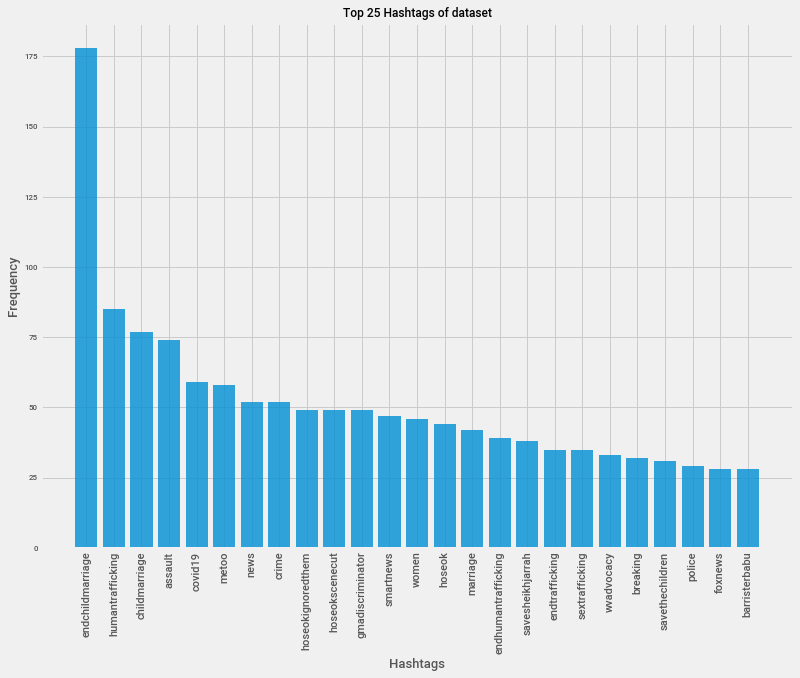

In [309]:
# Visualization of Top 25 Hashtags
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

labels = df_hashtags.head(25).index.values.tolist()
freq = df_hashtags['freq'].head(25).values.tolist()
index = np.arange(len(freq))

print("Among 53.939 Tweets, 15557 Hashtags were used.")
plt.figure(figsize=(12,9))
plt.bar(index, freq, alpha=0.8)
plt.xlabel('Hashtags', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(index, labels, fontsize=11, rotation=90, fontweight="bold") 
plt.title('Top 25 Hashtags of dataset', fontsize=12, fontweight="bold")
plt.show()

#Emoji Processing

##Fetch emoji from tweets

In [ ]:
emoji_tweets = df['tweet'].apply(str)

In [ ]:
import itertools
import emojis

emojis_list=[]

for tweet in emoji_tweets:
  emoji_present = list(emojis.get(tweet))
  if emoji_present:
    emojis_list.append(emoji_present)
    # One-Liner to union a list of sets
    emojis_list = list(itertools.chain.from_iterable(emojis_list))

In [ ]:
emojis_updated_list = [x for x in emojis_list if x !='️']
print(emojis_updated_list)

In [ ]:
from collections import Counter
Counter(emojis_updated_list).most_common()

##Emoji word cloud

In [ ]:
import string
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

class EmojiCloud:
    def __init__(self,
                 font_path='Symbola.ttf',
                 color='yellow'):
        self.font_path = font_path
        self.color = color
        self.word_cloud = self.initialize_wordcloud()
        self.emoji_probability = None

    def initialize_wordcloud(self):
        word_cloud = WordCloud(font_path=self.font_path,
                               width=2000,
                               height=1000,
                               background_color='white',
                               random_state=42,
                               collocations=False)
        return word_cloud

    def color_func(self, word, font_size, position, orientation, random_state=None,
                   **kwargs):
        hue_saturation = {
            'yellow': '42, 88%',
            'blue': '194, 49%',
            'green': '159, 42%',
            'grey': '45, 2%'
        }.get(self.color)

        current_emoji_probability = self.emoji_probability[word]
        # Use 50% opacity for emojis with 20% or more coverage
        if current_emoji_probability >= 0.20:
            opacity = 50
        else:
            # Use an opacity between 60 to 65 for other emojis
            opacity = 65 - current_emoji_probability/0.2 * 5
        return f"hsl({hue_saturation},{opacity}%)"

    def generate(self, emojis):
        emoji_frequencies = Counter(emojis)
        total_count = len(emojis)
        
        # Calculate probabilities of emojis from frequency counts
        self.emoji_probability = {emoji: count/total_count for emoji, count in emoji_frequencies.items()}
        
        # Use wordcloud library to generate a wordcloud of emojis
        wc = self.word_cloud.generate_from_frequencies(emoji_frequencies)
        
        # Recolor emojis according to their frequency
        plt.imshow(wc.recolor(color_func=self.color_func, random_state=42),
                   interpolation="bilinear")
        plt.axis("off")

In [ ]:
emoji_cloud = EmojiCloud(font_path='./Symbola.ttf', color='green')
emoji_cloud.generate(emojis_updated_list)

# Data Cleaning

##Drop N/A and remove duplicates

In [ ]:
df.dropna(inplace=True)
df.isna().sum()

In [ ]:
df.duplicated().sum()

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

## Text Preprocessing

In [ ]:
tweet = df['tweet']
tweet[6] 

In [ ]:
tweets = []
for sent in tweet:
  sent = re.sub('@[\w]+','',str(sent))
  tweets.append(sent)

In [ ]:
tweets[:6]

In [ ]:
df.columns

In [ ]:
df['new_tweets'] = tweets
# rearrange the order of the columns.
df = df[['date', 'time', 'username', 'tweet', 'new_tweets', 'replies_count', 'retweets_count','likes_count']]
df.head(2)

## Rename the columns

In [ ]:
data = df.rename(columns = {'replies_count':'replies',
                            'retweets_count':'retweets', 'likes_count':'likes'}, inplace=False)

df.columns

In [ ]:
data.columns

In [ ]:
data = data[['username', 'new_tweets', 'replies', 'retweets', 'likes']]
data.head(2)

In [ ]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

def cleaning(text, stem_words=True):    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

    stops = set(stopwords.words("english"))
    # Clean the text, with the option to stem words.
    
    # Empty question
    
    if type(text) != str or text=='':
        return ''

    # Clean the text
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub("[%s]" % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub("\w*\d\w*", "", text)


    text = re.sub("\'s", " ", text) 
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
    ## all numbers should separate from words, this is too aggressive
    
    def pad_number(pattern):
        matched_string = pattern.group(0)
        return pad_str(matched_string)
    text = re.sub('[0-9]+', pad_number, text)
    
    # add padding to punctuations and special chars, we still need them later
    
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    text = re.sub('amp', "", text)
    
    def pad_pattern(pattern):
       matched_string = pattern.group(0)
       return pad_str(matched_string)
    text = re.sub('[\!\?\@\^\+\*\/\,\~\|\`\=\:\;\.\#\\\]', pad_pattern, text) 
        
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) # replace non-ascii word with special word
    
    
    text = [c for c in text if c not in string.punctuation]
    text = [c for c in text if c != '\n'] # Removing newline
    text = ''.join(text)
    text = text.split('https')[0] # Remove links
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
    
    text = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(text))
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()
       # Return a list of words
    return text

In [ ]:
# Clean the tweets.
data['clean_tweets'] = data['new_tweets'].apply(cleaning)
data.head(5)

In [ ]:
def nonasciiword (text):
  text = re.sub("nonasciiword","",text)

  return text

data['clean_tweets'] = data['clean_tweets'].apply(nonasciiword)
data.head(3)

In [ ]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
data['tweets_without_stopwords'] = data['clean_tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data = data[['username', 'new_tweets', 'clean_tweets', 'tweets_without_stopwords', 'replies', 'retweets','likes']]
data.head(3)

In [ ]:
tweets_df = pd.DataFrame()
tweets_df['clean_tweets'] = data['tweets_without_stopwords']
tweets_df.head(2)

#Exploratory Data Analysis

In [ ]:
# importing sweetviz
import sweetviz as sv

In [ ]:
#to analyze the data and create a report, simply call analyze() method passing in the dataframe as argument
report = sv.analyze(data)

#display the report as html
report.show_html('tweets.html')

#### Word Cloud

In [ ]:
# Create a word cloud
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (12, 8))
    plt.imshow(wordcloud)
    plt.axis("off")
    
    plt.show()

In [ ]:
# display the word cloud.
cloud(' '.join(data['clean_tweets']))

In [ ]:
# Get Word Value Counts.
from collections import Counter
tweets_df['text_list'] = tweets_df['clean_tweets'].apply(lambda x:str(x).split())
top = Counter([item for sublist in tweets_df['text_list'] for item in sublist]) # Counts the frequency of words.
temp = pd.DataFrame(top.most_common(20)) # DataFrame of top 20
temp.columns = ["common_words", "count"]
temp.style.background_gradient(cmap="Blues")

In [ ]:
data.to_csv("GBV_data_clean_v01.csv")

In [ ]:
#saving the data
from google.colab import files
files.download('GBV_data_clean_v01.csv')